# Imports

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from imutils import paths
import os
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from numpy import argmax
import pandas as pd
import cv2
import seaborn as sn

# Importando e preparando o dataset e estabelecendo rótulos

In [2]:
caminho = 'dataset_final/'
files = list(paths.list_images(caminho))

data = []
labels = []

for file in files:
    label = file.split(os.path.sep)[-2]
    
    image = load_img(file, target_size=(224, 224)) # carrega as imagens e estabelece o tamanho desejado de 224x224
    
    image = img_to_array(image) # transforma as imagens em array
    
    image = preprocess_input(image) # retorna um numpy array float32

    data.append(image)
    labels.append(label)

data = np.array(data, dtype="float32")
labels = np.array(labels)

lb = LabelBinarizer()

labels = lb.fit_transform(labels) # transforma os labels em um array de 0 e 1

labels = to_categorical(labels) # transforma os labels em one-hot

(trainX, testX, trainY, testY) = train_test_split(data, labels,test_size=0.90, stratify=labels, random_state=42)

# Estabelecendo hiperparâmetros: Learning Rate, Batch Size e Epochs

In [3]:
INIT_LR = 1e-4
BS = 20
EPOCHS = 32

# Carrega a rede da MobileNet sem o topo

In [4]:
baseModel = MobileNet(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))

# Fazendo as camadas do topo

In [5]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# Colocando o topo do nosso modelo sobre o modelo base

In [6]:
model = Model(inputs=baseModel.input, outputs=headModel)

# Congelando as camadas no modelo base para elas não serem atualizadas durante o primeiro processo de treinamento

In [7]:
for layer in baseModel.layers:
    layer.trainable = False

# Compilando o modelo

In [8]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / BS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

callback = EarlyStopping(monitor='accuracy', patience=5)

H = model.fit(trainX, trainY, BS, EPOCHS)

Epoch 1/32
50/50 [==============================] - 11s 197ms/step - loss: 0.6023 - accuracy: 0.7444
Epoch 2/32
50/50 [==============================] - 10s 199ms/step - loss: 0.2320 - accuracy: 0.9446
Epoch 3/32
50/50 [==============================] - 10s 202ms/step - loss: 0.1156 - accuracy: 0.9822
Epoch 4/32
50/50 [==============================] - 10s 200ms/step - loss: 0.0696 - accuracy: 0.9930
Epoch 5/32
50/50 [==============================] - 10s 209ms/step - loss: 0.0590 - accuracy: 0.9901
Epoch 6/32
50/50 [==============================] - 10s 199ms/step - loss: 0.0397 - accuracy: 0.9930
Epoch 7/32
50/50 [==============================] - 10s 209ms/step - loss: 0.0319 - accuracy: 0.9949
Epoch 8/32
50/50 [==============================] - 10s 197ms/step - loss: 0.0229 - accuracy: 0.9973
Epoch 9/32
50/50 [==============================] - 10s 200ms/step - loss: 0.0195 - accuracy: 0.9980
Epoch 10/32
50/50 [==============================] - 10s 195ms/step - loss: 0.0230 - accura

# Salvando o modelo treinado

In [9]:
model.save('modelo/modelo.h5')

# Teste

## Relatório de classificação

<AxesSubplot:>

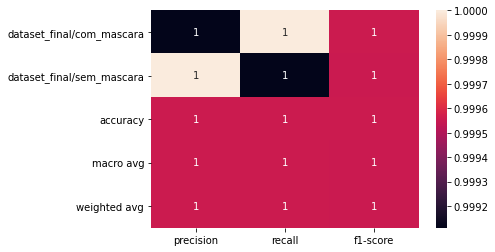

In [14]:
preds = model.predict(testX, batch_size=32)
preds = np.argmax(preds, axis=1)
labels = np.arange(2)
clf_report = classification_report(testY.argmax(axis=1),
                                   preds,
                                   labels=labels,
                                   target_names=lb.classes_,
                                   output_dict=True)
sn.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)

## Matriz de confusão

Text(15.0, 0.5, 'Valores Reais')

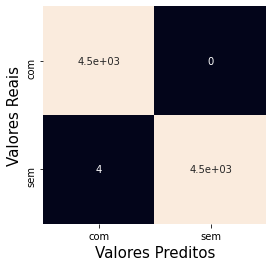

In [15]:
confusao = confusion_matrix(testY.argmax(axis=1), preds)
df_cm = pd.DataFrame(confusao,
                     index = ['com', 'sem'],
                     columns = ['com', 'sem'])
plt.figure(figsize = (4,4))
sn.heatmap(df_cm,
           cbar=False,
           annot=True)
plt.xlabel("Valores Preditos", fontsize=15)
plt.ylabel("Valores Reais", fontsize=15)